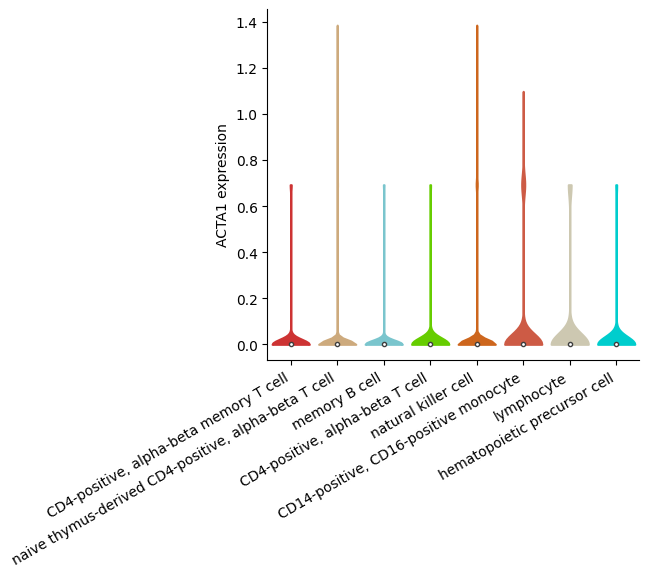

In [3]:
from typing import List
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64

def sql_query(query):
    # postgres data retrieval with consistent output, both in the jupyter development
    # environment (plpy is not available) and at runtime inside a plpython3u stored procedure
    try:
        import plpy
    except:
        from postgres_utils import engine
        from sqlalchemy import text
        with engine.connect() as connection:
            r = connection.execute(text(query))            
            return [row._mapping for row in r.fetchall()]    
    r = plpy.execute(query)
    return [row for row in r]

def get_annotated_samples_expression(study_id:int, study_layer_id:int, omics_id:int, annotation_group_id: int, exclude_annotation_value_ids: List[int]):
    expression_records = sql_query(f"""
        select e.study_sample_ids, e.values
            from expression e
        where e.study_layer_id={study_layer_id} and e.omics_id={omics_id}""")
    df = pd.DataFrame(expression_records)
    samples_expression_df = df.explode('study_sample_ids').drop(columns=['values'])
    samples_expression_df['value'] = df.explode('values')['values']
    samples_expression_df = samples_expression_df.astype({'study_sample_ids': 'int32', 'value': 'float32'})

    sample_annotation_records = sql_query(f"""
        select av.display_value, ssa.study_sample_ids
        from   annotation_value av
               join study_sample_annotation ssa on av.annotation_value_id = ssa.annotation_value_id
        where av.annotation_group_id = {annotation_group_id} and ssa.study_id={study_id}
        {" and av.annotation_value_id not in (" + ",".join([str(i) for i in exclude_annotation_value_ids]) + ")" if exclude_annotation_value_ids else ""};""")
    sample_annotation_df = pd.DataFrame(sample_annotation_records).explode('study_sample_ids').set_index('study_sample_ids')

    # 'right' join and fillna:
    # we need to identify 'not measured' samples and set their expression value to 0,
    # otherwise scarce expression values lead to a high violin. It makes more sense to assume that the not measured
    # cells have a low expression for the gene in question.
    sample_annotation_values_df = samples_expression_df.join(sample_annotation_df, on='study_sample_ids', how='right')
    sample_annotation_values_df.fillna(value=0.0, inplace=True)
    sample_annotation_values_df.reset_index(drop=True, inplace=True)
    return sample_annotation_values_df, sample_annotation_df, samples_expression_df

def get_palette(annotation_group_id: int):
    annotation_values = sql_query(f"select av.display_value, av.color from annotation_value av where av.annotation_group_id = {annotation_group_id}")
    palette = {e['display_value']: e['color'] for e in annotation_values}
    return palette

def get_omics_symbol(omics_id: int):
    r = sql_query(f"select display_symbol from omics_base where omics_id={omics_id}")
    return r[0]['display_symbol']

def seaborn_to_base64() -> str:
    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight")
    plt.close()
    s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    return f"data:image/png;base64,{s}"

# https://stackoverflow.com/questions/41567205/outer-lines-seaborn-violinplot-boxplot
def _patch_violinplot_remove_violin_edge_line(ax):
    from matplotlib.collections import PolyCollection
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_edgecolor(art.get_facecolor())

def generate_plot(study_id:int, study_layer_id:int, omics_id:int, annotation_group_id: int, exclude_annotation_value_ids: List[int]):
    assert type(study_id) == int
    assert type(study_layer_id) == int
    assert type(omics_id) == int
    assert type(annotation_group_id) == int
    assert type(exclude_annotation_value_ids) == list
    df,_,_ = get_annotated_samples_expression(study_id, study_layer_id, omics_id, annotation_group_id, exclude_annotation_value_ids)
    groupByAttribute = 'display_value'

    unique_x_values = len(df[groupByAttribute].unique())

    max_x_values_chars = max([len(name) for name in df[groupByAttribute].unique()])
    fig, ax = plt.subplots(figsize=((unique_x_values * 1.0) * 0.6, (5 + max_x_values_chars * 0.05) * 0.6))
    sns.violinplot(ax=ax, data=df, y='value',
                           x='display_value', # annotation category
                           #order=_get_ordered_attributevalues(df, groupByAttribute),
                           #hue=secondaryGroupByAttribute,
                           #hue_order=_get_ordered_attributevalues(df,
                           #                                       secondaryGroupByAttribute) if secondaryGroupByAttribute else None,
                           palette=get_palette(annotation_group_id),
                           saturation=1,
                           cut=0,
                           scale='width',
                           inner='box')
    # get rid of legend, which shows by default in 'hue' mode
    plt.legend([], [], frameon=False)
    _patch_violinplot_remove_violin_edge_line(ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set(xlabel=None, ylabel=f"{get_omics_symbol(omics_id)} expression")
    sns.despine(fig)

generate_plot(1, 1, 8356, 1, [1,2,3,4,5])

#generate_plot(20, 20, 8356, 4)
#sample_annotation_values_df, sample_annotation_df, samples_expression_df = get_annotated_samples_expression(2, 2, 8356, 1)

#seaborn_to_base64()



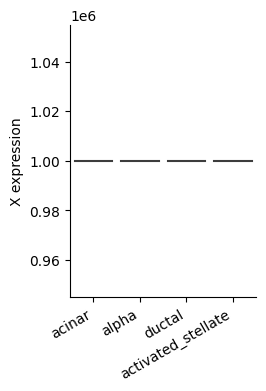

In [27]:
from IPython import display
im = 'data:image/png;base64,.iVBORw0K........'

display.HTML(f'<img src="{im}" />')

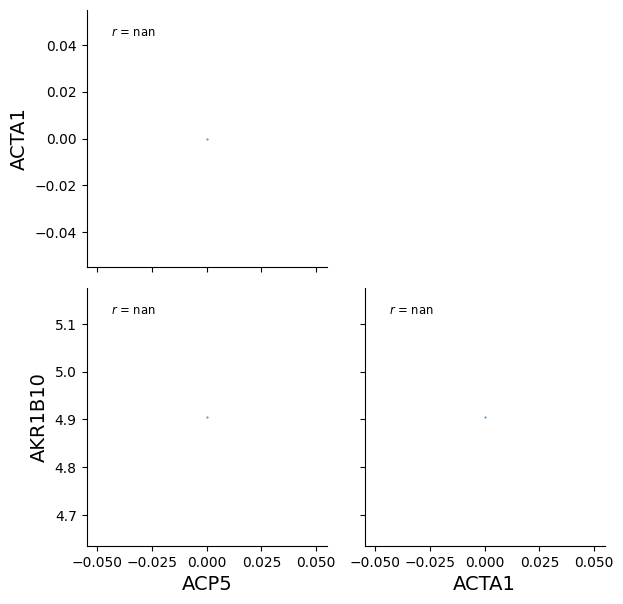

In [37]:

from typing import List
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64

def sql_query(query):
    # postgres data retrieval with consistent output, both in the jupyter development
    # environment (plpy is not available) and at runtime inside a plpython3u stored procedure
    try:
        import plpy
    except:
        from postgres_utils import engine
        from sqlalchemy import text
        with engine.connect() as connection:
            r = connection.execute(text(query))            
            return [row._mapping for row in r.fetchall()]    
    r = plpy.execute(query)
    return [row for row in r]

def get_omics_symbols_map(omics_ids: List[int]):
    result = sql_query(f"select omics_id, display_symbol from omics_base where omics_id IN ({','.join([str(i) for i in omics_ids])})")
    return {row['omics_id']: row['display_symbol'] for row in result}

def get_expression_correlation_df(study_layer_id: int, omics_ids: List[int]):
    expression_records = sql_query(f"""
            select e.omics_id, e.study_sample_ids, e.values
                from expression e
            where e.study_layer_id={study_layer_id} and e.omics_id IN ({','.join([str(i) for i in omics_ids])})""")
    df = pd.DataFrame(expression_records)
    samples_expression_df = df.explode('study_sample_ids').drop(columns=['values'])
    samples_expression_df['value'] = df.explode('values')['values']
    samples_expression_df = samples_expression_df.astype({'study_sample_ids': 'int32', 'value': 'float32'})
    correlation_df = samples_expression_df.pivot_table(values='value', index='study_sample_ids', columns='omics_id', aggfunc='first').fillna(0.0)
    correlation_df.rename(columns=get_omics_symbols_map(omics_ids), inplace=True)
    return correlation_df

def get_exclude_sample_ids_df(study_id: int, exclude_annotation_value_ids: List[int]):
    if exclude_annotation_value_ids:
        exclude_sample_ids = sql_query(f"""
            select ssa.study_sample_ids
            from   study_sample_annotation ssa
            where  ssa.annotation_value_id in (  {",".join([str(i) for i in exclude_annotation_value_ids])}  ) 
            and ssa.study_id = {study_id}
            """)
        exclude_sample_ids_df = pd.DataFrame(exclude_sample_ids)
        exclude_sample_ids_df = exclude_sample_ids_df.explode('study_sample_ids')
        exclude_sample_ids_df.set_index('study_sample_ids', inplace=True)
        return exclude_sample_ids_df


def sns_scatter_matrix_lower(df):
    def corrfunc(x, y, **kwargs):
        plot_data = pd.DataFrame({'x':x, 'y':y})
        # filter out cells which have no expression for both of the genes, so that the 'not measured'
        # data doesn't inflate the correlation
        either_gene_expressed = plot_data[(plot_data.loc[:, 'x'] > 0) | (plot_data.loc[:, 'y'] > 0)]
        r = either_gene_expressed.corr(method='pearson').loc['x', 'y']
        ax = plt.gca()
        ax.annotate("$r$ = {:.2f}".format(r), xy=(.1, .9), xycoords=ax.transAxes, fontsize='small')

    grid = sns.PairGrid(data=df, vars=list(df), height=3)
    for m, n in zip(*np.triu_indices_from(grid.axes, k=0)):
        grid.axes[m, n].set_visible(False)
    grid = grid.map_lower(plt.scatter, s=0.2)
    grid.map_lower(corrfunc)
    plt.rcParams["axes.labelsize"] = 14
    


def generate_correlation_plot(study_id: int, study_layer_id: int, omics_ids: List[int], exclude_annotation_value_ids: List[int]):
    correlation_df = get_expression_correlation_df(study_layer_id, omics_ids)
    if exclude_annotation_value_ids:
        exclude_sample_ids_df = get_exclude_sample_ids_df(study_id, exclude_annotation_value_ids)
        correlation_df = correlation_df[~correlation_df.index.isin(exclude_sample_ids_df.index)]
    sns_scatter_matrix_lower(correlation_df)
    

def seaborn_to_base64() -> str:
    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight")
    plt.close()
    s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    return f"data:image/png;base64,{s}"

generate_correlation_plot(1, 1, [2670,8356,16870], [1,2,3,4,5,6,7,8,9])